# Import Initial Libraries & Establish S3 Session

In [86]:
!pip install --disable-pip-version-check -q fast_ml

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [87]:
import boto3
import sagemaker
import pandas as pd
import io
import functools
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler
from fast_ml.model_development import train_valid_test_split

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
s3 = boto3.client("s3")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

# Downlaod Key Data from S3 & Save to Local Sagemaker Instance

In [18]:
def download_s3_files(filename):
    obj = s3.get_object(Bucket=bucket, Key=filename)
    pd.read_csv(io.BytesIO(obj['Body'].read())).to_csv(filename)
    
    print("Successfully downloaded file: {}".format(filename))
    
files = ['college_statistics.csv',
         'combine_data.csv',
         'nfl_draft_profiles.csv',
         'draft_picks.csv',
         'nfl_draft_prospects.csv']

for file in files:
    download_s3_files(file)

Successfully downloaded file: college_statistics.csv
Successfully downloaded file: combine_data.csv
Successfully downloaded file: nfl_draft_profiles.csv
Successfully downloaded file: draft_picks.csv
Successfully downloaded file: nfl_draft_prospects.csv


# Read Data into Dataframes

In [19]:
def read_csv(filename):
    df = pd.read_csv(filename)
    print("Successfuly read {} records into df".format(len(df)))
    
    return df

# Data Quality Checks

## College Statistics

Initially, certain columns have been immmediately dropped or pivoted, based on domain knowledge, usefulness to the problem at hand and ease of analysis.

Further, it can be seen that there are many NaN's in this dataset. However, these NaN's occur in areas where they are expected; certain players are not expected to have any stats for certain metrics. For example, defensive players are not expected to have offensive stats and vice-versa.

Hence, all NaN's in this case will be filled with 0.0.

A data type check was also performed to sense-check that each field is formatted appropriately.

In [20]:
college_stats = read_csv('college_statistics.csv').pivot_table(index=['player_id','player_name','alt_player_id','pos_abbr','school', 'school_abbr', 'season','all_star'],columns='statistic', values='value')\
                                                  .reset_index()

Successfuly read 66672 records into df


In [21]:
print(college_stats.isna().sum())
print(college_stats.dtypes)

college_stats.fillna(0.0, inplace=True)

statistic
player_id                         0
player_name                       0
alt_player_id                     0
pos_abbr                          0
school                            0
                               ... 
Total Touchdowns               2186
Total Two Point Conversions    2186
Yards Per Pass Attempt         3323
Yards Per Reception            2443
Yards Per Rush Attempt         2745
Length: 66, dtype: int64
statistic
player_id                        int64
player_name                     object
alt_player_id                    int64
pos_abbr                        object
school                          object
                                ...   
Total Touchdowns               float64
Total Two Point Conversions    float64
Yards Per Pass Attempt         float64
Yards Per Reception            float64
Yards Per Rush Attempt         float64
Length: 66, dtype: object


## Combine Data

The Round & Pick columns were immediately removed from this dataset, as there is another dataset dedicated to that information; and all datasets will be combined in the next phase of exploration.

For the remainging columns, NaN's were found across key metrics. On a cost-benefit analysis of dropping NaN's (to preserve data integrity as physical fitness information is critical to draft strategies) vs. replacing Nan's with 0's; the latter option was chosen to ensure enough data was present for a model to successfully learn and avoid overfitting. Dropping NaN's enitrely would reduce the dataset to an unnaceptable level, which is indeed a data quality issue.  0 is chosen because players can opt not to participate in certain drills.  Using a median or mean metric to replace NaN's can produce invalid predictions.

In [23]:
combine = read_csv('combine_data.csv').drop(columns=['Round', 'Pick', 'Pfr_ID', 'AV','Team','Unnamed: 0'])

Successfuly read 6218 records into df


In [24]:
print(combine.isna().sum())
print(combine.dtypes)

combine.fillna(0, inplace=True)

Player          0
Pos             0
Ht              0
Wt              0
Forty         172
Vertical     1422
BenchReps    2006
BroadJump    1464
Cone         2225
Shuttle      2155
Year            0
dtype: int64
Player        object
Pos           object
Ht             int64
Wt             int64
Forty        float64
Vertical     float64
BenchReps    float64
BroadJump    float64
Cone         float64
Shuttle      float64
Year           int64
dtype: object


## Draft Picks

Unfortunately in this dataset, the player_id field contained many NaN's and was hence dropped. Instead, the player name (pfr_name) will be used to join data sets.

In [25]:
picks = read_csv('draft_picks.csv').drop(columns=['Unnamed: 0','pfr_id'])

Successfuly read 11632 records into df


In [26]:
print(picks.isna().sum())
print(picks.dtypes)

picks.drop(columns='player_id', inplace=True)

season           0
team             0
round            0
pick             0
pfr_name         0
player_id    11395
side             0
category         0
position         0
dtype: int64
season        int64
team         object
round         int64
pick          int64
pfr_name     object
player_id    object
side         object
category     object
position     object
dtype: object


## Draft Prospects

This dataset had many NaN's. The key data in this set, that cannot be found in the other datasets above, were player position ranks and overall ranks, which would be crucial to draft order. 

As such, all other columns were dropped (apart from player identifiers), and NaN's were removed as the rank information cannot be imputed. 

In [27]:
prospects = read_csv('nfl_draft_prospects.csv')

Successfuly read 13354 records into df


In [28]:
print(prospects.isna().sum())
print(prospects.dtypes)

Unnamed: 0            0
draft_year            0
player_id             0
player_name           0
position            309
pos_abbr            309
school              209
school_name         227
school_abbr         396
link                  0
pick               1566
overall            1566
round              1566
traded             1566
trade_note         8848
team               1566
team_abbr          1566
team_logo_espn     1600
guid               7182
weight             7242
height             7273
pos_rk             7365
ovr_rk             8134
grade              7359
player_image      11823
dtype: int64
Unnamed: 0          int64
draft_year          int64
player_id           int64
player_name        object
position           object
pos_abbr           object
school             object
school_name        object
school_abbr        object
link               object
pick              float64
overall           float64
round             float64
traded             object
trade_note         obje

# Exploratory Data Analysis

## College Statistics

We perform quick EDA to get a feel for the data distributions, features we are working with, just to get an idea of how this data can benefit our project

In [29]:
college_stats.describe()

statistic,player_id,alt_player_id,season,Assist Tackles,Completion Percentage,Completions,Extra Points Made,FGM 1-19 yards,FGM 20-29 yards,FGM 30-39 yards,...,Solo Tackles,Total Kicking Points,Total Points,Total Sacks,Total Tackles,Total Touchdowns,Total Two Point Conversions,Yards Per Pass Attempt,Yards Per Reception,Yards Per Rush Attempt
count,3624.000000,3.624000e+03,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,...,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000
mean,100543.730960,3.847922e+06,2017.200607,9.809327,4.681098,7.633554,0.417494,0.001932,0.045530,0.043046,...,14.735099,0.853753,12.958885,0.680464,24.544426,2.018902,0.024834,0.727649,3.968543,1.203974
std,14482.151791,4.195900e+05,1.517690,13.341449,18.153404,42.477853,4.438662,0.049804,0.530985,0.507543,...,18.035017,8.976746,25.115141,3.835349,30.055744,3.981081,0.165941,3.603123,6.511709,3.060852
min,368.000000,2.985844e+06,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,-12.000000,-13.000000
25%,103548.750000,3.728263e+06,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,104097.000000,3.957672e+06,2017.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,104737.250000,4.048231e+06,2018.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,25.000000,0.000000,12.000000,0.000000,42.000000,2.000000,0.000000,0.000000,8.400000,0.000000
max,105468.000000,4.579254e+06,2020.000000,96.000000,100.000000,493.000000,85.000000,2.000000,12.000000,11.000000,...,109.000000,134.000000,198.000000,46.000000,181.000000,33.000000,3.000000,59.000000,58.000000,37.500000


Looking at the descriptive statistics, we are quickly alarmed by the season column.  The data only contains information for players from year 2014 to 2020.  This means we have so many years of data missing.  Due to time constraints, we are unable to gather the missing information.  Since we are not able to apply this data to all of the players in consideration, we must withdraw this data source.

## Combine Data

We now consider the combine data for EDA.

In [30]:
combine.describe()

,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,Year
count,6218.000000,6218.000000,6218.000000,6218.000000,6218.000000,6218.000000,6218.000000,6218.000000,6218.000000
mean,73.798971,243.372145,4.651457,25.313284,14.175137,87.116275,4.676463,2.868932,2009.041975
std,2.621373,45.103814,0.840625,14.272668,11.108602,49.029161,3.507552,2.100832,5.471056
min,65.000000,149.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000
25%,72.000000,206.000000,4.530000,24.500000,0.000000,93.000000,0.000000,0.000000,2004.000000
50%,74.000000,233.000000,4.690000,31.500000,17.000000,111.000000,6.940000,4.180000,2009.000000
75%,76.000000,281.000000,4.970000,35.000000,23.000000,119.000000,7.320000,4.430000,2014.000000
max,82.000000,375.000000,6.050000,46.000000,49.000000,147.000000,9.120000,5.560000,2018.000000


We now observe a boxplot of each of the numeric features within Combine.

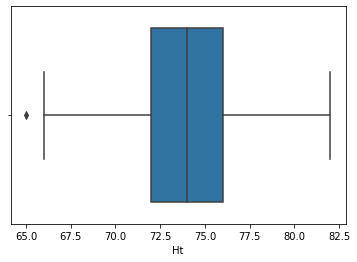

In [31]:
import seaborn as sns

sns.boxplot(x=combine['Ht'])

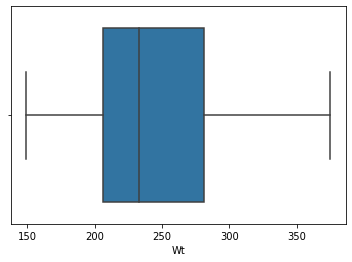

In [32]:
sns.boxplot(x=combine['Wt'])

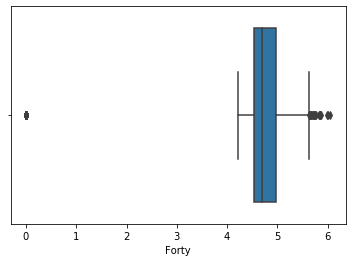

In [33]:
sns.boxplot(x=combine['Forty'])

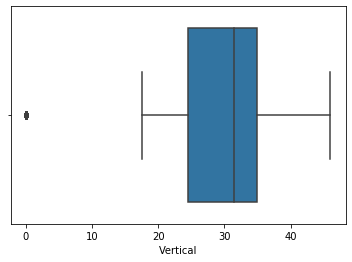

In [34]:
sns.boxplot(x=combine['Vertical'])

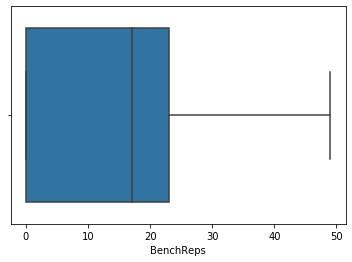

In [35]:
sns.boxplot(x=combine['BenchReps'])

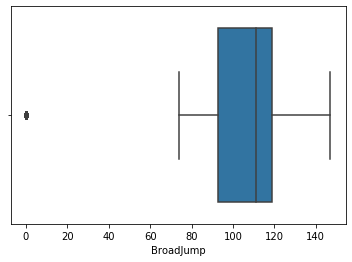

In [36]:
sns.boxplot(x=combine['BroadJump'])

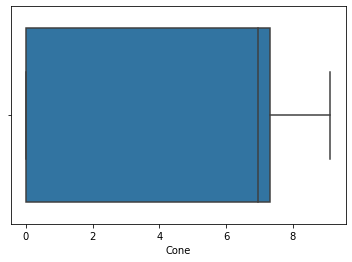

In [37]:
sns.boxplot(x=combine['Cone'])

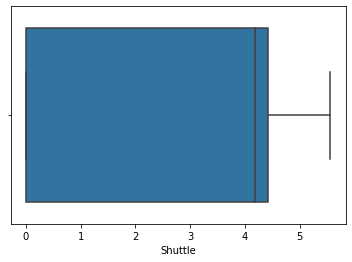

In [38]:
sns.boxplot(x=combine['Shuttle'])

It should be obvious from the scope of this project that the important features are all physical to the player: Height, Weight, Forty Time, Vertical, Bench Reps, Broad Jump, Cone, and Shuttle.  Some players do elect not to participate in a given drill.

## Draft Picks

In [39]:
picks.describe()

,season,round,pick
count,11632.000000,11632.000000,11632.000000
mean,1999.270117,5.065853,141.761778
std,12.378608,2.869793,84.830973
min,1980.000000,1.000000,1.000000
25%,1988.000000,3.000000,70.000000
50%,1999.000000,5.000000,139.000000
75%,2010.000000,7.000000,208.000000
max,2021.000000,12.000000,336.000000


The draft picks data is metadata for our players.  It includes information about what pick the player was drafted and what year.  We found while looking at other data that a lot of information we plan to use only started to be recorded in 2004.  So, we will limit our analysis to 2004 data and up.

## Draft Prospects

In [40]:
prospects.describe()

,Unnamed: 0,draft_year,player_id,pick,overall,round,weight,height,pos_rk,ovr_rk,grade
count,13354.000000,13354.000000,13354.000000,11788.000000,11788.000000,11788.000000,6112.000000,6081.000000,5989.000000,5220.000000,5995.000000
mean,6676.500000,1998.189831,29884.278718,16.905921,113.918392,4.110875,244.736093,73.941169,15.862581,156.325670,57.787490
std,3855.112082,16.116808,28600.931243,10.123831,67.882416,2.004959,86.888394,2.684655,14.069466,96.825064,20.367434
min,0.000000,1967.000000,1.000000,1.000000,1.000000,1.000000,155.000000,38.000000,1.000000,1.000000,20.000000
25%,3338.250000,1984.000000,13684.250000,8.000000,56.000000,2.000000,205.000000,72.000000,6.000000,73.000000,39.000000
50%,6676.500000,2001.000000,20725.500000,16.000000,112.000000,4.000000,234.000000,74.000000,13.000000,148.000000,57.000000
75%,10014.750000,2012.000000,28963.750000,24.000000,167.000000,6.000000,285.000000,76.000000,22.000000,235.000000,74.000000
max,13353.000000,2021.000000,105496.000000,54.000000,262.000000,7.000000,6022.000000,81.625000,151.000000,373.000000,99.000000


There aren't any useful visualizations for this data.  We are interested in pos_rk, ovr_rk, and grade, but these are subjective values assigned by domain experts.  Obviously, we expect to see higher picks where the grade is high.

# Merge Datasets for Data Cleansing

The code below will join the datasets into one final dataframe for feature analysis/selection and model training.

Initially, the following columns have been dropped based on their usefulness to the overall goal (determined by domain-knowledge). A conservative approach has been taken to only remove fields that create noise, whilst leaving as many potentially useful fields as possible for further analysis.

Many fields were also dropped as they were duplicated across datasets (e.g. draft pick and round features in multiple datasets, the duplicated were dropped).

In [76]:
df = pd.merge(combine, picks, left_on = ['Player', 'Year'], right_on = ['pfr_name', 'season'])
df2 = pd.merge(df, prospects, left_on = ['Player', 'Year'], right_on = ['player_name', 'draft_year'])
print(df2.columns)

Index(['Player', 'Pos', 'Ht', 'Wt', 'Forty', 'Vertical', 'BenchReps',
       'BroadJump', 'Cone', 'Shuttle', 'Year', 'season', 'team_x', 'round_x',
       'pick_x', 'pfr_name', 'side', 'category', 'position_x', 'Unnamed: 0',
       'draft_year', 'player_id', 'player_name', 'position_y', 'pos_abbr',
       'school', 'school_name', 'school_abbr', 'link', 'pick_y', 'overall',
       'round_y', 'traded', 'trade_note', 'team_y', 'team_abbr',
       'team_logo_espn', 'guid', 'weight', 'height', 'pos_rk', 'ovr_rk',
       'grade', 'player_image'],
      dtype='object')


In [77]:
df2.drop(columns=['Pos','Year','team_x','round_x','pick_x','pfr_name','category', 'Unnamed: 0', 'draft_year','player_id','player_name', 'position_y', 'pos_abbr',
       'school_name', 'school_abbr', 'link', 'traded','trade_note', 'ovr_rk',
       'team_abbr','team_logo_espn', 'guid', 'weight', 'height','player_image'], inplace=True)
df2.head()

,Player,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,season,side,position_x,school,pick_y,overall,round_y,team_y,pos_rk,grade
0,John Abraham,76,252,4.55,0.0,0.0,0.0,0.00,0.00,2000,D,DE,South Carolina,13.0,13.0,1.0,New York Jets,NaN,NaN
1,Shaun Alexander,72,218,4.58,0.0,0.0,0.0,0.00,0.00,2000,O,RB,Alabama,19.0,19.0,1.0,Seattle Seahawks,NaN,NaN
2,Darnell Alford,76,334,5.56,25.0,23.0,94.0,8.48,4.98,2000,O,G,Boston College,22.0,188.0,6.0,Kansas City Chiefs,NaN,NaN
3,Rashard Anderson,74,206,4.55,34.0,0.0,123.0,7.18,4.15,2000,D,DB,Jackson State,23.0,23.0,1.0,Carolina Panthers,NaN,NaN
4,LaVar Arrington,75,250,4.53,0.0,0.0,0.0,0.00,0.00,2000,D,LB,Penn State,2.0,2.0,1.0,Washington Redskins,NaN,NaN


After analysis, we determined that we have missing data for players prior to the 2004 season.  Therefore, we will only maintain data for players from 2004 and up.

In [78]:
df2_final = df2[df2['season'] >= 2004]

Now we double check our missing data.  Since the count is super low, we will just drop the missing data.  Some of the missing data is a result of one player having multiple entries.  If we had more time, we could correct this issue.

In [81]:
print(df2_final.isna().sum())

Player         0
Ht             0
Wt             0
Forty          0
Vertical       0
BenchReps      0
BroadJump      0
Cone           0
Shuttle        0
season         0
side           0
position_x     0
school         4
pick_y         8
overall        8
round_y        8
team_y         8
pos_rk        12
grade         11
dtype: int64


In [82]:
df2_final.dropna(inplace=True)
print(df2_final.isna().sum())

Player        0
Ht            0
Wt            0
Forty         0
Vertical      0
BenchReps     0
BroadJump     0
Cone          0
Shuttle       0
season        0
side          0
position_x    0
school        0
pick_y        0
overall       0
round_y       0
team_y        0
pos_rk        0
grade         0
dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Feature Transformation: Encoding and Scaling

As can be seen in the dataset that remains, there are many categorical fields remaining:

- Player: The player that is being selected.
- position_x: the position label of the player, crucial to their draft order and competition.
- school: the college the player attended
- side: Denotes whether a player is a defensive or offensive player, again vital to their draft prospects.
- team_y: the NFL team that drafted the player

In [91]:
label_encoder = LabelEncoder()
df2_final['Player'] = label_encoder.fit_transform(df2_final['Player'])
df2_final['position_x'] = label_encoder.fit_transform(df2_final['position_x'])
df2_final['school'] = label_encoder.fit_transform(df2_final['school'])
df2_final['side'] = label_encoder.fit_transform(df2_final['side'])
df2_final['team_y'] = label_encoder.fit_transform(df2_final['team_y'])

In [92]:
df2_final.head()

,Player,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,season,side,position_x,school,pick_y,overall,round_y,team_y,pos_rk,grade
785,853,69,179,4.58,33.5,0.0,120.0,6.89,4.08,2004,1,18,85,43.0,244.0,7.0,2,39.0,39.0
786,2167,75,254,4.65,33.0,0.0,118.0,0.00,4.36,2004,0,3,212,13.0,145.0,5.0,26,19.0,56.0
787,2716,75,307,5.01,0.0,0.0,0.0,0.00,0.00,2004,0,5,144,11.0,74.0,3.0,3,12.0,73.0
788,621,78,269,4.89,30.0,17.0,106.0,7.86,4.45,2004,1,17,166,44.0,245.0,7.0,24,9.0,64.0
789,2584,78,342,5.07,30.5,34.0,106.0,8.09,4.78,2004,1,16,147,27.0,123.0,4.0,6,15.0,55.0


Finally, all fields except for overall (the target variable) have been scaled to feed into our model(s).

In [93]:
scaler = MinMaxScaler()
df2_final.loc[:,~df2_final.columns.isin(['overall'])] = scaler.fit_transform(df2_final.loc[:,~df2_final.columns.isin(['overall'])])

In [94]:
df2_final.head()

,Player,Ht,Wt,Forty,Vertical,BenchReps,BroadJump,Cone,Shuttle,season,side,position_x,school,pick_y,overall,round_y,team_y,pos_rk,grade
785,0.289055,0.2500,0.078818,0.782906,0.744444,0.000000,0.816327,0.804907,0.758364,0.0,0.5,1.000000,0.372807,0.807692,244.0,1.000000,0.060606,0.339286,0.240506
786,0.734327,0.6250,0.448276,0.794872,0.733333,0.000000,0.802721,0.000000,0.810409,0.0,0.0,0.166667,0.929825,0.230769,145.0,0.666667,0.787879,0.160714,0.455696
787,0.920366,0.6250,0.709360,0.856410,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.277778,0.631579,0.192308,74.0,0.333333,0.090909,0.098214,0.670886
788,0.210437,0.8125,0.522167,0.835897,0.666667,0.346939,0.721088,0.918224,0.827138,0.0,0.5,0.944444,0.728070,0.826923,245.0,1.000000,0.727273,0.071429,0.556962
789,0.875635,0.8125,0.881773,0.866667,0.677778,0.693878,0.721088,0.945093,0.888476,0.0,0.5,0.888889,0.644737,0.500000,123.0,0.500000,0.181818,0.125000,0.443038


## Upload final dataframe to S3 for easy access

In [95]:
df2_final.to_csv('cleanedData.csv')

In [106]:
def to_s3(bucket, filename, content):
    client = boto3.client('s3')
    k = "datafiles/"+filename
    client.put_object(Bucket=bucket, Key=k, Body=content)

In [107]:
from io import BytesIO
csv_buffer = BytesIO()
to_s3(bucket, "cleanedData.csv", csv_buffer.getvalue())